In [1]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

In [2]:
# Make a request
url = 'https://covid19.ncdc.gov.ng'
response = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"})

In [3]:
print(response.text[:500])

<!DOCTYPE html>
<html lang="en">
<meta http-equiv="content-type" content="text/html;charset=UTF-8" />
<head>
<title>NCDC Coronavirus COVID-19 Microsite</title>
<!--[if lt IE 11]>
    	<script src="https://oss.maxcdn.com/libs/html5shiv/3.7.0/html5shiv.js"></script>
    	<script src="https://oss.maxcdn.com/libs/respond.js/1.4.2/respond.min.js"></script>
    	<![endif]-->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=0, minimal-ui">
<meta


In [4]:
# Create a beautifulsoup object
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [5]:
# Locate table
covid_table = html_soup.find('div', class_ = 'table-responsive')

In [6]:
# Scrape table headers and pass into a list
table_heading = covid_table.thead.find_all('th')
headings = []
for th in table_heading:
    headings.append(th.text)
print(headings)

['States Affected', 'No. of Cases (Lab Confirmed)', 'No. of Cases (on admission)', 'No. Discharged', 'No. of Deaths']


In [7]:
# Scrape table rows and pass into a list
table_rows = []
for i in covid_table.tbody.find_all('tr'):
    table_rows.append(i.text.replace('\n', ' ').strip())
table_rows

['Lagos  6,266  5,215  970  81',
 'FCT  1,097  792  280  25',
 'Kano  1,025  453  522  50',
 'Edo  478  336  117  25',
 'Ogun  475  248  214  13',
 'Rivers  403  202  179  22',
 'Katsina  399  169  209  21',
 'Oyo  398  279  112  7',
 'Kaduna  383  140  233  10',
 'Borno  381  150  205  26',
 'Bauchi  374  134  230  10',
 'Jigawa  309  148  156  5',
 'Gombe  246  100  135  11',
 'Delta  197  136  50  11',
 'Ebonyi  152   82  70  0',
 'Kwara  143  72  70  1',
 'Plateau  130  28  99  3',
 'Sokoto  129  13  102  14',
 'Nasarawa  127  91  31  5',
 'Abia  97  81  16  0',
 'Imo  83   64  19  0',
 'Zamfara  76  0  71  5',
 'Yobe  52  20  25  7',
 'Ondo  50  13  29  8',
 'Osun  50  6  40  4',
 'Anambra  46  42  3  1',
 'Niger  46   19  26  1',
 'Akwa Ibom  45  28  15  2',
 'Kebbi  43  10  29  4',
 'Adamawa  42  4  34  4',
 'Enugu  35  20  14  1',
 'Bayelsa  32  12  17  3',
 'Ekiti  30  10  18  2',
 'Taraba  18  8  10  0',
 'Benue  13  12  1  0',
 'Kogi  3  3  0  0']

In [8]:
# Format table rows for dataframe
table_rows = [i.split() for i in table_rows]
table_rows

[['Lagos', '6,266', '5,215', '970', '81'],
 ['FCT', '1,097', '792', '280', '25'],
 ['Kano', '1,025', '453', '522', '50'],
 ['Edo', '478', '336', '117', '25'],
 ['Ogun', '475', '248', '214', '13'],
 ['Rivers', '403', '202', '179', '22'],
 ['Katsina', '399', '169', '209', '21'],
 ['Oyo', '398', '279', '112', '7'],
 ['Kaduna', '383', '140', '233', '10'],
 ['Borno', '381', '150', '205', '26'],
 ['Bauchi', '374', '134', '230', '10'],
 ['Jigawa', '309', '148', '156', '5'],
 ['Gombe', '246', '100', '135', '11'],
 ['Delta', '197', '136', '50', '11'],
 ['Ebonyi', '152', '82', '70', '0'],
 ['Kwara', '143', '72', '70', '1'],
 ['Plateau', '130', '28', '99', '3'],
 ['Sokoto', '129', '13', '102', '14'],
 ['Nasarawa', '127', '91', '31', '5'],
 ['Abia', '97', '81', '16', '0'],
 ['Imo', '83', '64', '19', '0'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Yobe', '52', '20', '25', '7'],
 ['Ondo', '50', '13', '29', '8'],
 ['Osun', '50', '6', '40', '4'],
 ['Anambra', '46', '42', '3', '1'],
 ['Niger', '46', '19',

In [9]:
# Join 'Akwa' and 'Ibom'
del table_rows[27][1]
table_rows[27][0] = 'Akwa Ibom'
table_rows

[['Lagos', '6,266', '5,215', '970', '81'],
 ['FCT', '1,097', '792', '280', '25'],
 ['Kano', '1,025', '453', '522', '50'],
 ['Edo', '478', '336', '117', '25'],
 ['Ogun', '475', '248', '214', '13'],
 ['Rivers', '403', '202', '179', '22'],
 ['Katsina', '399', '169', '209', '21'],
 ['Oyo', '398', '279', '112', '7'],
 ['Kaduna', '383', '140', '233', '10'],
 ['Borno', '381', '150', '205', '26'],
 ['Bauchi', '374', '134', '230', '10'],
 ['Jigawa', '309', '148', '156', '5'],
 ['Gombe', '246', '100', '135', '11'],
 ['Delta', '197', '136', '50', '11'],
 ['Ebonyi', '152', '82', '70', '0'],
 ['Kwara', '143', '72', '70', '1'],
 ['Plateau', '130', '28', '99', '3'],
 ['Sokoto', '129', '13', '102', '14'],
 ['Nasarawa', '127', '91', '31', '5'],
 ['Abia', '97', '81', '16', '0'],
 ['Imo', '83', '64', '19', '0'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Yobe', '52', '20', '25', '7'],
 ['Ondo', '50', '13', '29', '8'],
 ['Osun', '50', '6', '40', '4'],
 ['Anambra', '46', '42', '3', '1'],
 ['Niger', '46', '19',

In [10]:
# Pass table rows into data frame
data = pd.DataFrame(table_rows)
data.head()

,0,1,2,3,4
0,Lagos,"6,266","5,215",970,81
1,FCT,"1,097",792,280,25
2,Kano,"1,025",453,522,50
3,Edo,478,336,117,25
4,Ogun,475,248,214,13


In [11]:
# Set table headers from headings list
data.columns = headings
data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"6,266","5,215",970,81
1,FCT,"1,097",792,280,25
2,Kano,"1,025",453,522,50
3,Edo,478,336,117,25
4,Ogun,475,248,214,13


In [12]:
# Remove all commas from columns
data.replace(',','', regex=True, inplace=True)

In [13]:
col = data.select_dtypes(object).columns[1:]
data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [14]:
data.dtypes

States Affected                 object
No. of Cases (Lab Confirmed)     int64
No. of Cases (on admission)      int64
No. Discharged                   int64
No. of Deaths                    int64
dtype: object

In [15]:
# Rename FCT to Abuja FCT
data.loc[data['States Affected'] == 'FCT', 'States Affected'] = 'Federal Capital Territory'

In [16]:
data.columns = ['States', 'Cases', 'Infected', 'Recoveries', 'Deaths']

In [17]:
data.head(3)

,States,Cases,Infected,Recoveries,Deaths
0,Lagos,6266,5215,970,81
1,Federal Capital Territory,1097,792,280,25
2,Kano,1025,453,522,50


In [18]:
# Export data frame to csv
data.to_csv('covid_nigeria.csv')

In [19]:
# Import libararies for map plotting
import geopandas as gpd
import geoplot as gpt
import matplotlib.pyplot as plt

In [20]:
# Load SHP files
shp = r'shapefile/Nigeria_Poly.shp'
shapefile = gpd.read_file(shp)

In [21]:
type(shapefile), shapefile.shape

(geopandas.geodataframe.GeoDataFrame, (37, 16))

In [22]:
shapefile.columns

Index(['id', 'country', 'name', 'enname', 'locname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2', 'geometry'],
      dtype='object')

In [23]:
# Drop unecassary columns
shapefile = shapefile.drop(['id', 'country', 'name', 'enname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2'], axis=1)

In [24]:
shapefile.columns = ['States', 'geometry']

In [25]:
shapefile.head(2)

,States,geometry
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7...."
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ..."


In [26]:
# Merge GeoDataFrame with covid statistics data
data = shapefile.merge(data, left_on='States', right_on='States')

In [27]:
type(data), data.shape

(geopandas.geodataframe.GeoDataFrame, (36, 6))

In [28]:
data.head(2)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",97,81,16,0
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,4,34,4


In [29]:
data.head(3)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",97,81,16,0
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,4,34,4
2,Akwa Ibom,"MULTIPOLYGON (((8.34338 4.60775, 8.34241 4.606...",45,28,15,2


In [30]:
# Define plot function
from jupyterthemes import jtplot
def visual(data, hue, cmap, theme):
    #context: 'paper' (Default), 'notebook', 'talk', or 'poster'
    #theme: 'oceans16', 'grade3', 'chesterish', 'onedork', 'monokai', 'solarizedl', 'solarizedd'
    jtplot.style(theme=theme, context='poster', grid=True, gridlines='-', ticks=True, spines=True, fscale=1.2) #figsize=(8.0, 7.0))
    fig, ax = plt.subplots(1, figsize=(38, 13))
    ax.set_title('Coronavirus {} by States'.format(hue), fontdict={'fontsize': '20', 'fontweight' : '3'})
    gpt.choropleth(data, hue=hue, cmap=cmap,
                   legend=True,edgecolor='lightgray', linewidth=0.1,
                   ax=ax,legend_kwargs={'aspect':30, 'fraction':0.036,'pad':0.00, 'orientation':'horizontal'});

    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    for idx, row in data.iterrows():
        ax.annotate(s=row['States'], xy=row['coords'], color='black', fontsize=13, horizontalalignment='center')
        plt.savefig('{}.png'.format(hue))

In [ ]:
# Plot geomap for cases
visual(data, 'Cases', 'RdYlBu', theme)

In [ ]:
# Plot geomap for recoveries
visual(data, 'Recoveries', 'Blues', theme)

In [ ]:
# Plot geomap for deaths
visual(data, 'Deaths', 'YlGnBu', theme)

<h1 align='center'>Time Series Data</h1>

<p>Download data from Johns Hopkins University (JHU) Center for Systems Science and Engineering's (CSSE) GitHub repository</p>

In [203]:
cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [204]:
recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [205]:
deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [298]:
# Read data into data frame
df_cases = pd.read_csv(cases)
df_recovs = pd.read_csv(recovs)
df_deaths = pd.read_csv(deaths)

In [299]:
# Extract confirmed cases data for Nigeria
df_cases.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_cases.set_index('Country/Region', inplace=True)
df_cases = df_cases.loc['Nigeria']
df_cases = pd.DataFrame(df_cases)
df_cases.columns = ['Cases']

In [300]:
# Extract recoveries data for Nigeria
df_recovs.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovs.set_index('Country/Region', inplace=True)
df_recovs = df_recovs.loc['Nigeria']
df_recovs = pd.DataFrame(df_recovs)
df_recovs.columns = ['Recoveries']

In [301]:
# Extract death data for Nigeria
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths.set_index('Country/Region', inplace=True)
df_deaths = df_deaths.loc['Nigeria']
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Deaths']

In [302]:
# Merge cases, recoveriies and death data into one data frame
time_series = pd.concat([df_cases, df_recovs, df_deaths], axis=1, ignore_index=False)

In [303]:
# Rename columns
time_series.reset_index(inplace=True)
time_series.columns = ['Time', 'Cases', 'Recoveries', 'Deaths']

In [305]:
# Set time column type to datetime

#date = pd.date_range("1 22 2020", periods=time_series.shape[0], freq="D", name="date")
time_series['Time'] = pd.to_datetime(time_series['Time'], errors='coerce')

In [306]:
# Make time column index of the data frame
time_series.set_index('Time', inplace=True)

In [307]:
time_series.head()

,Cases,Recoveries,Deaths
Time,,,
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


In [310]:
# Export time series data to csv
time_series.to_csv('time_series.csv')

In [308]:
# Import libraries for plotting
import seaborn as sns
from jupyterthemes import jtplot

Text(0.5, 0, 'Time')

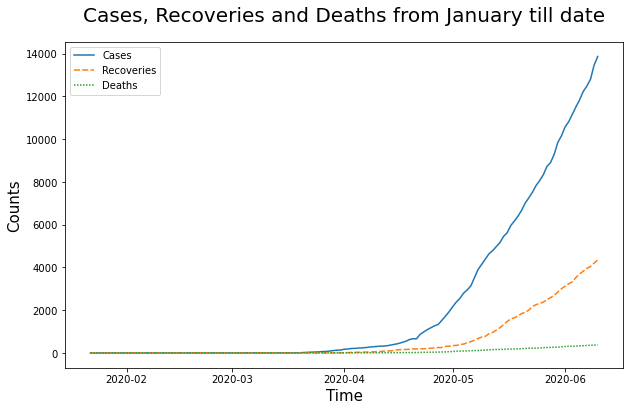

In [325]:
#context: 'paper' (Default), 'notebook', 'talk', or 'poster'
#theme: 'oceans16', 'grade3', 'chesterish', 'onedork', 'monokai', 'solarizedl', 'solarizedd'
#jtplot.style(theme=oceans16, context='poster', grid=True, gridlines='-', ticks=True, spines=True, fscale=1.2) #figsize=(8.0, 7.0))
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=time_series)
ax.set_title('Cases, Recoveries and Deaths from January till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})